# Example: Bike Travel

From PDSH Chapter 3.11

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Gather data of bike activity on Fremont Bridge bike traffic


In [2]:
!curl -o ../data/FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4293k    0 4293k    0     0  1402k      0 --:--:--  0:00:03 --:--:-- 1402k:--:--  0:00:01 --:--:-- 1187k


In [3]:
df = pd.read_csv('../data/FremontBridge.csv', parse_dates=['Date'], index_col='Date')
df = df.loc['2015':'2017']
df.columns = ['Total','East','West']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52608 entries, 2015-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Total   52598 non-null  float64
 1   East    52598 non-null  float64
 2   West    52598 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB


In [4]:
f'proportion missing: {sum(df.Total.isna()) / len(df):0.5f}'

'proportion missing: 0.00019'

In [5]:
df = df.fillna(method='ffill')
print(df.head(3))

                     Total  East  West
Date                                  
2015-01-01 00:00:00   13.0   4.0   9.0
2015-01-01 01:00:00   27.0   4.0  23.0
2015-01-01 02:00:00   19.0   5.0  14.0


In [6]:
df.loc['2015']

,Total,East,West
Date,,,
2015-01-01 00:00:00,13.0,4.0,9.0
2015-01-01 01:00:00,27.0,4.0,23.0
2015-01-01 02:00:00,19.0,5.0,14.0
2015-01-01 03:00:00,6.0,0.0,6.0
2015-01-01 04:00:00,5.0,2.0,3.0
...,...,...,...
2015-12-31 19:00:00,23.0,10.0,13.0
2015-12-31 20:00:00,12.0,2.0,10.0
2015-12-31 21:00:00,16.0,8.0,8.0


### plot data from 2015


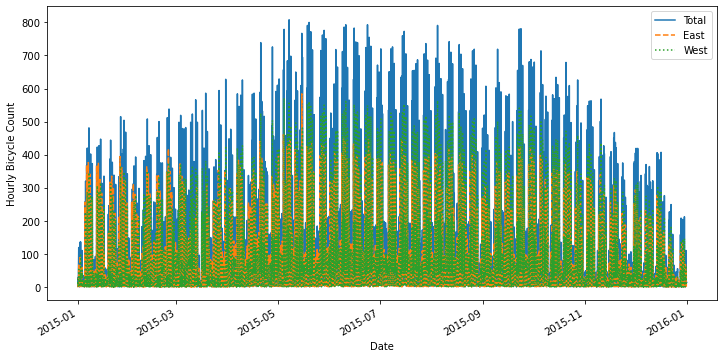

In [7]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
df.loc['2015'].plot(style=['-', '--', ':'],ax=ax)
plt.ylabel('Hourly Bicycle Count');

### downsample to weekly sum to smooth things out


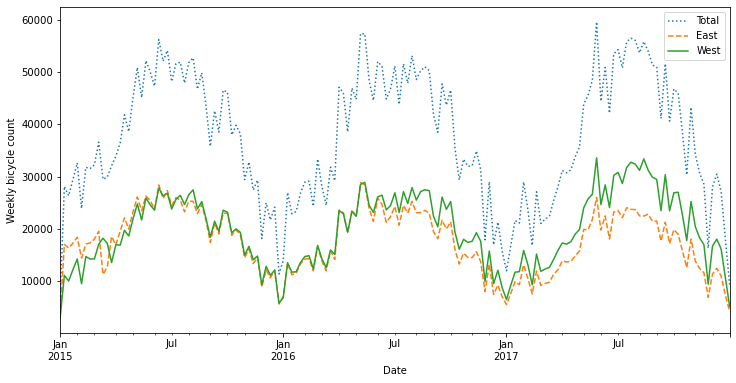

In [8]:
weekly = df.resample('W').sum()
weekly.plot(style=[':', '--', '-'], figsize=(12,6))
plt.ylabel('Weekly bicycle count');

### resample at daily for a more granular view then apply a rolling window of 30 days to smooth things out

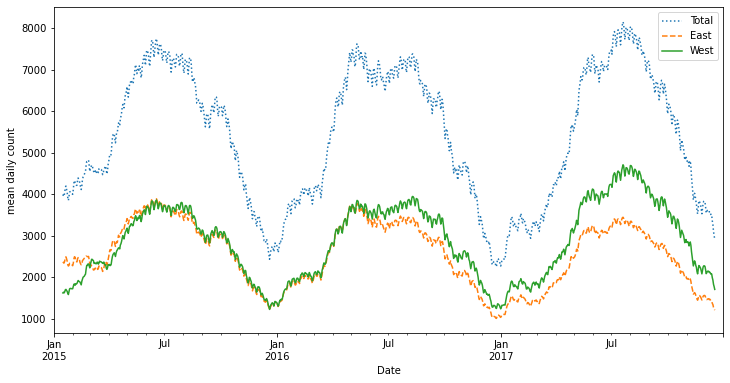

In [9]:
daily = df.resample('D').sum()
daily.rolling(30,center=True).mean().plot(style=[':', '--', '-'], figsize=(12,6))
plt.ylabel('mean daily count');

### a wider window using a gaussian filter smooths more while accentuating daily differences

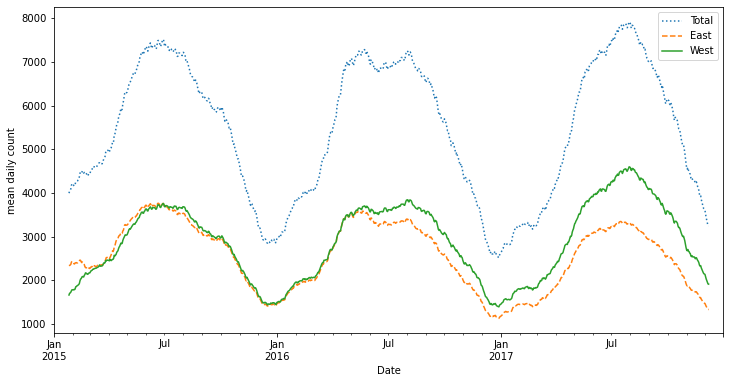

In [10]:
daily.rolling(50,center=True,win_type='gaussian').mean(std=30).plot(style=[':','--','-'],figsize=(12,6));
plt.ylabel('mean daily count');

# From Datetime to Time

In [11]:
#If we want to only look at time of day
df.index.time

array([datetime.time(0, 0), datetime.time(1, 0), datetime.time(2, 0), ...,
       datetime.time(21, 0), datetime.time(22, 0), datetime.time(23, 0)],
      dtype=object)

In [12]:
#Get mean data by time (hourly)
by_time = df.groupby(df.index.time).mean()
print(by_time.head(3))

              Total      East      West
00:00:00  11.319343  4.806569  6.512774
01:00:00   5.743613  2.613139  3.130474
02:00:00   3.615876  1.687956  1.927920


Text(0, 0.5, 'mean hourly count')

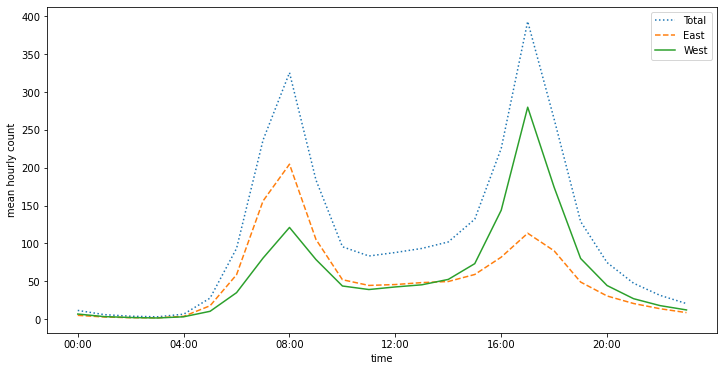

In [13]:
hourly_ticks = 60 * 60 * 4 * np.arange(6)  # sec * min * every4hours
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-'], figsize=(12,6));
plt.ylabel('mean hourly count')

### can also look at average by day of week

/home/bgibson/anaconda3/envs/eods-f20/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


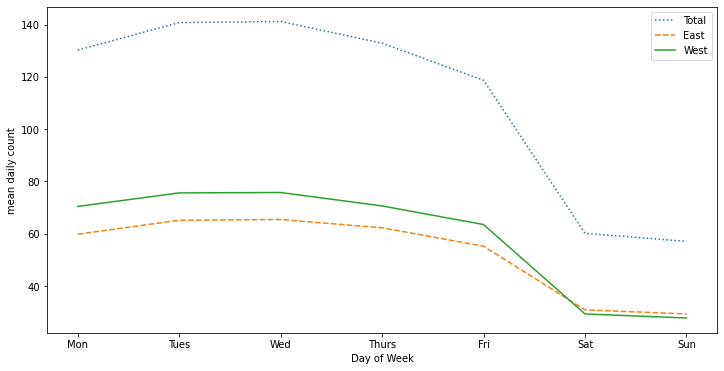

In [14]:
# note that for dayofweek: 0 == Mon, 1 == Tues,..., 6 == 'Sun'
by_weekday = df.groupby(df.index.dayofweek).mean()
by_weekday = by_weekday.set_index(pd.Index(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']))

fig,ax = plt.subplots(1,1,figsize=(12,6))
by_weekday.plot(style=[':', '--', '-'], ax=ax);
ax.set_xlabel('Day of Week');ax.set_ylabel('mean daily count');

### separate out weekdays and weekends

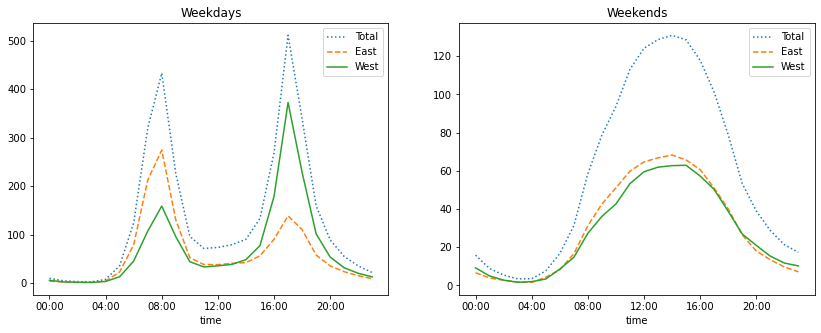

In [15]:
# create a weekend mask
weekend = np.where(df.index.weekday < 5, 'Weekday', 'Weekend')

# get hourly mean values split by weekday, weekend
by_time = df.groupby([weekend, df.index.time]).mean()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays', xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks, style=[':', '--', '-']);


## Can we predict daily Total bike traffic?

In [16]:
bike_counts = pd.read_csv('../data/FremontBridge.csv', index_col='Date', parse_dates=True)
bike_weather = pd.read_csv('../data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [17]:
# define target
daily = bike_counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
print(daily.head(3))

              Total
Date               
2012-10-03  14084.0
2012-10-04  13900.0
2012-10-05  12592.0


In [18]:
# add 'day of week' one-hot features
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
print(daily.head(3))

              Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun
Date                                                  
2012-10-03  14084.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2012-10-04  13900.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2012-10-05  12592.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0


In [19]:
# add 'is it a holiday' dummy feature
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')

daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)
print(daily.head(3))

              Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday
Date                                                           
2012-10-03  14084.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0
2012-10-04  13900.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0
2012-10-05  12592.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0


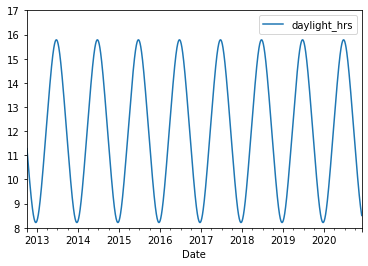

In [20]:
# add number of hours of daylight
from datetime import datetime

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index));

daily[['daylight_hrs']].plot();
plt.ylim(8, 17);

In [21]:
#Add weather information (can we predict this for future dates?)

# temperatures are in 1/10 deg C; convert to C
bike_weather['TMIN'] /= 10
bike_weather['TMAX'] /= 10
bike_weather['Temp (C)'] = 0.5 * (bike_weather['TMIN'] + bike_weather['TMAX'])

# precip is in 1/10 mm; convert to inches
bike_weather['PRCP'] /= 254
bike_weather['dry day'] = (bike_weather['PRCP'] == 0).astype(int)

daily = daily.join(bike_weather[['PRCP', 'Temp (C)', 'dry day']])
daily.head(3)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0


In [22]:
# add how far into the year we are?
daily['annual'] = (daily.index - daily.index[0]).days / 365.
daily.head(3)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# drop any rows with missing data
daily.dropna(axis=0, how='any', inplace=True)

X = daily[daily.columns[daily.columns != 'Total']]
y = daily.Total

X_train,X_test,y_train,y_test = train_test_split(X,y)

model = LinearRegression(fit_intercept=False)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8649176878630449

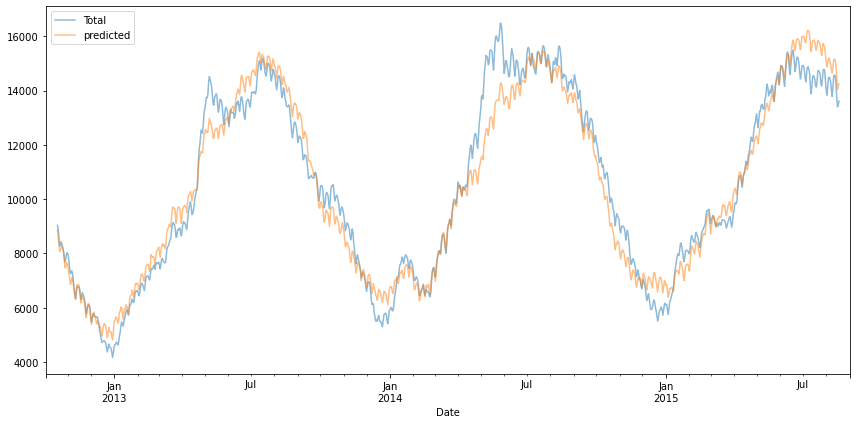

In [24]:
daily['predicted'] = model.predict(X)
daily[['Total', 'predicted']].rolling(30, center=True).mean().plot(alpha=0.5,figsize=(12,6))
plt.tight_layout()